# Módulo 1: Análisis de datos en el ecosistema Python

### Sesión (7)

**16/10/2023**

# Regularización

Recordemos que la **regresión lineal múltiple** era un modelo que intentaba extraer una relación entre la variable objetivo y una serie de variables independientes que actuaban como los predictores del modelo, mediante **una ecuación lineal**.  

Existen en la práctica una serie de limitaciones comunes que uno se podría afrontar a la hora de ajustar este tipo de modelos como:  
- La presencia de **predictores correlacionadas**.  
- Incluir todas las variables independientes **sin realizar una selección** previa de predictores.  

Las técnicas de regularización como ***Ridge***, ***Lasso*** o ***Elastic Net*** intentan forzar a que los coeficientes del modelo tiendan a cero para:  
- Conseguir un modelo más **simple**, más generalizado y evitar el ***overfitting***.  
- Mitigar el efecto de la **correlación** entre los predictores.   

Volvemos a generar un modelo para predecir los precios de viviendas en Boston:

In [11]:
# importamos las librerías necesarias 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [12]:
# Modificamos los parámetros de los gráficos en matplotlib
from matplotlib.pyplot import rcParams

rcParams['figure.figsize'] = 12, 6 # el primer dígito es el ancho y el segundo el alto
rcParams["font.weight"] = "bold"
rcParams["font.size"] = 10
rcParams["axes.labelweight"] = "bold"

### Boston housing dataset

> #### **¡Nota importante!**  
> El conjunto de datos de precios de la vivienda de _Boston_ tiene un **`problema ético`**:  
  como se investigó en [este artículo](https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8), los autores de este conjunto de datos diseñaron una variable no invertible **"B" asumiendo que la autosegregación racial tuvo un impacto positivo en los precios de la vivienda**.  
>   
>  Además, el objetivo de la investigación que condujo a la creación de este conjunto de datos fue estudiar el impacto de la calidad del aire, pero **no proporcionó una demostración adecuada de la validez de dicha suposición**.
 Por lo tanto, los mantenedores de _scikit-learn_ **desaconsejan fuertemente** el uso de este conjunto de datos a menos que el propósito del  código sea **estudiar y educar sobre cuestiones éticas** en la ciencia de datos y el aprendizaje automático. 
>  
> A partir de la *versión 1.2 de Scikit-learn* **se ha eluminado este conjunto de datos**. Sin embargo, se puede descargar en las versiones anteriores o de forma manual: 

In [13]:
### Para versiones < 1.2

# Importamos los datos de la misma librería de scikit-learn
# from sklearn.datasets import load_boston
from pandas import read_csv


boston = read_csv("dataset_boston.csv", index_col=0)

# Convertir los datos en pandas dataframe
dataframe_x = pd.DataFrame(boston.data, columns = boston.feature_names)

# La variable dependiente es el target y la llamammos dataframe_y
dataframe_y = pd.DataFrame(boston.target, columns = ['target'])

# Combinamos ambos para obtener un dataframe con todas las variables explicativas y la variable objetivo
df_boston = dataframe_x.join(dataframe_y)

df_boston

AttributeError: 'DataFrame' object has no attribute 'data'

In [14]:
# cargar el dataset de boston
df_boston = pd.read_csv("dataset_boston.csv", index_col=0)
df_boston

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


Características del conjunto de datos:
 
    -Número de muestras: 506
 
    -Número de atributos: 13 predictivo numérico / categórico
 
    -Median value (atributo 14) suele ser el objetivo.
    
Información de atributos (en orden):

        - CRIM tasa de delincuencia per cápita por ciudad
        - Proporción ZN de terreno residencial dividido en zonas para lotes de más de 25,000 pies cuadrados.
        - Proporción INDUS de acres comerciales no minoristas por ciudad 
        - Variable ficticia CHAS Charles River (= 1 si el tramo limita con el río; 0 en caso contrario)
        - Concentración de óxidos nítricos NOX (partes por 10 millones)
        - RM número medio de habitaciones por vivienda
        - Proporción de EDAD de las unidades ocupadas por el propietario construidas antes de 1940
        - Distancias ponderadas DIS a cinco centros de empleo de Boston
        - Índice RAD de accesibilidad a carreteras radiales
        - IMPUESTO Tasa de impuesto a la propiedad de valor total por \$ 10,000\
        - PTRATIO Ratio maestro-alumno por municipio
        - B 1000 (Bk - 0.63) ^ 2 donde Bk es la proporción de negros por ciudad
        - LSTAT % menor estatus de la población
        - MEDV Valor medio de las viviendas ocupadas por el propietario en \$ 1000\

Definimos los datos del modelo con todas las variables de entrada **menos la variable éticamente incorrecta**


In [15]:
X_multiple = df_boston.drop(['target', 'B'], axis='columns')
y_multiple = df_boston['target']

A pesar de que es una práctica común y recomendada, esta vez no modificamos la *[estructura de datos](https://scikit-learn.org/stable/glossary.html#term-array-like)* antes de pasarlo al modelo.

In [16]:
X_multiple

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,6.48


In [17]:
y_multiple

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: target, Length: 506, dtype: float64

In [18]:
# Dividir el dataset en Training y Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=124)

In [19]:
from sklearn.linear_model import LinearRegression


lr_multiple = LinearRegression()

In [20]:
# Entrenamos el modelo
lr_multiple.fit(X_train, y_train)

LinearRegression()

In [21]:
# Conseguir la predicción (para el conjunto de test que son los datos no vistos por el algoritmo en la fase de modelización)
y_pred_multiple = lr_multiple.predict(X_test)

In [22]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(lr_multiple.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(lr_multiple.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[-1.31655093e-01  4.85176793e-02 -8.79855065e-03  2.83832241e+00
 -1.86314949e+01  3.82478607e+00  8.22246554e-03 -1.41509254e+00
  2.78510233e-01 -1.29899052e-02 -8.81718077e-01 -5.38203875e-01]

 Valor de la intersección o coeficiente "b":
39.05276989196371


In [23]:
# Creamos una tabla de los parámetros del modelo ajustado
df_coef = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_coef['coeficientes'] = lr_multiple.coef_
df_coef


,variables,coeficientes
0,CRIM,-0.131655
1,ZN,0.048518
2,INDUS,-0.008799
3,CHAS,2.838322
4,NOX,-18.631495
5,RM,3.824786
6,AGE,0.008222
7,DIS,-1.415093
8,RAD,0.278510
9,TAX,-0.012990


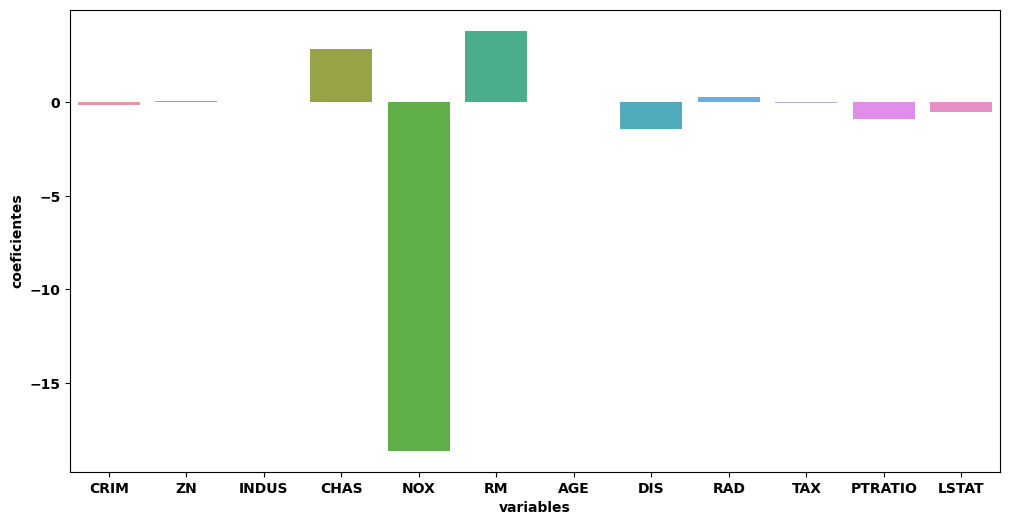

In [24]:
# Visualizamos los coeficientes del modelo
sns.barplot(x=df_coef['variables'], y=df_coef['coeficientes'])
plt.show()

In [25]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_multiple))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_multiple)*100)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_multiple))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_multiple)))
print('R^2 coefficient of determination:', r2_score(y_test, y_pred_multiple))

Mean Absolute Error: 3.515498444984276
Mean Absolute Percentage Error: 17.69606004473016
Mean Squared Error: 23.660632436308582
Root Mean Squared Error: 4.864219612261414
R^2 coefficient of determination: 0.7242504521835381


## Ridge (L2)

En la ecuación genérica de un modelo de regresión lineal múltiple con ***`n`*** observaciones y ***`m`*** predictores, los coeficientes del modelo son los pesos que controlan la participación y por lo tanto la influencia de cada predictor en el modelo:

##### $y=b_{0} + b_{1}x_{1}+ b_{2}x_{2}+ b_{3}x_{3}+ ...+ b_{m}x_{m}$

El algoritmo por defecto busca cómo reducir la función de coste, que generalmente es el error cuadrático medio (*Mean Squared Error*) de las estimaciones en el conjunto de datos de entrenamiento (mínimos cuadrados):

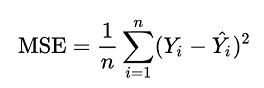

La regularización **Ridge** conocida también como **L2**, **penaliza la suma de los coeficientes del modelo al cuadrado**. El principal efecto que causa el hecho de añadir este término a la función de coste del algoritmo es la **reducción proporcional del valor de todos los coeficientes** del modelo, sin que necesariamente lleguen a cero.  

El grado de penalización está controlado por el **hiperparámetro $\alpha$**.

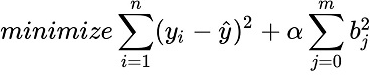

A continuación aplicamos el método de ***Ridge Regression*** sobre el mismo planteamiento del dataset de Boston 

In [26]:
# importamos el "ridge regression" desde la misma librería de sklearn
from sklearn.linear_model import Ridge
 
# Entrenamos 
L2_reg = Ridge(alpha = 1)
L2_reg.fit(X_train, y_train)
y_pred_l2 = L2_reg.predict(X_test)

In [27]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(L2_reg.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(L2_reg.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[-1.29550834e-01  4.93742460e-02 -4.45704458e-02  2.61229578e+00
 -1.02647099e+01  3.88933083e+00  4.18189682e-04 -1.28972998e+00
  2.65107736e-01 -1.39717518e-02 -7.94003828e-01 -5.45184508e-01]

 Valor de la intersección o coeficiente "b":
33.45826197484362


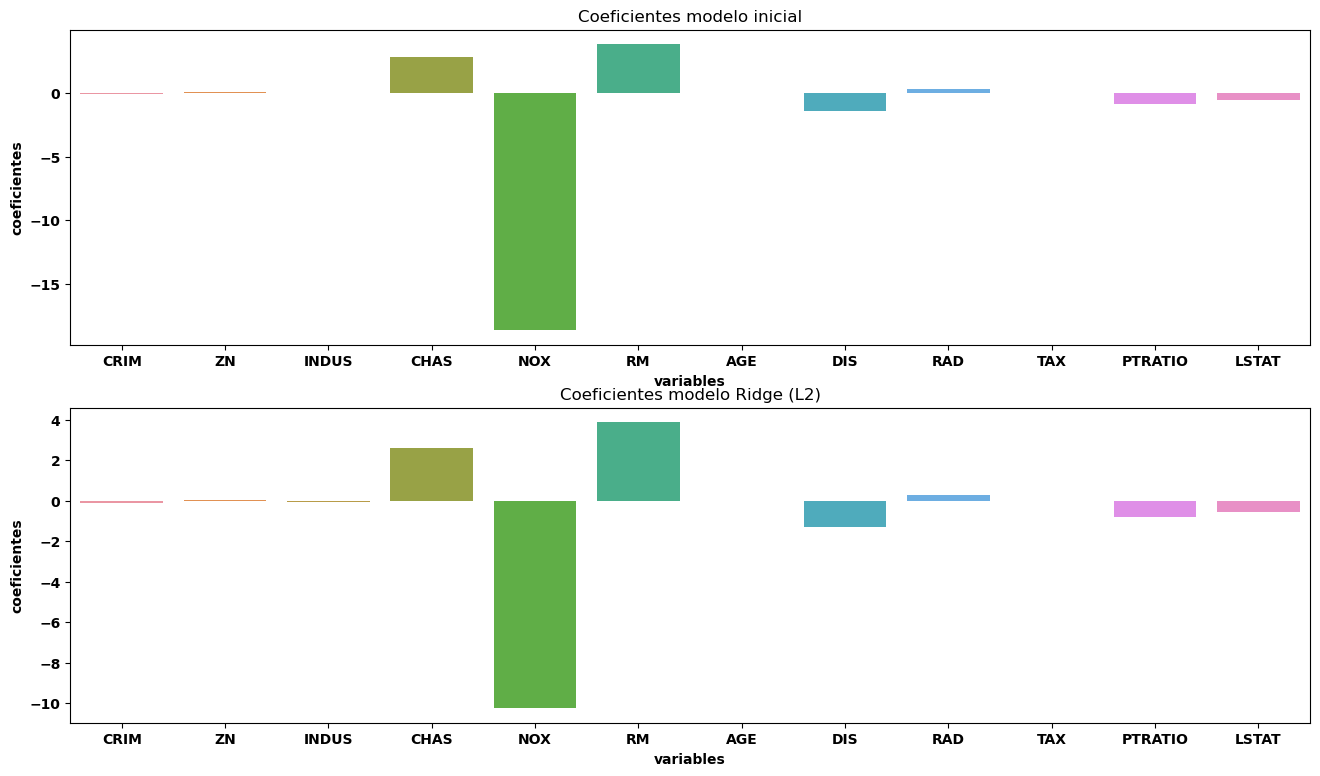

In [28]:
# Visualizamos los coeficientes del modelo
df_coef_l2 = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_coef_l2['coeficientes'] = L2_reg.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef['variables'], y=df_coef['coeficientes'], ax=axes[0], )
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_l2['variables'], y=df_coef_l2['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Ridge (L2)")

plt.show()

In [29]:
L2_reg.coef_

array([-1.29550834e-01,  4.93742460e-02, -4.45704458e-02,  2.61229578e+00,
       -1.02647099e+01,  3.88933083e+00,  4.18189682e-04, -1.28972998e+00,
        2.65107736e-01, -1.39717518e-02, -7.94003828e-01, -5.45184508e-01])

In [30]:
df_coef_l2

,variables,coeficientes
0,CRIM,-0.129551
1,ZN,0.049374
2,INDUS,-0.044570
3,CHAS,2.612296
4,NOX,-10.264710
5,RM,3.889331
6,AGE,0.000418
7,DIS,-1.289730
8,RAD,0.265108
9,TAX,-0.013972


Como se puede ver la diferencia principal del modelo *Ridge* está en contener coeficientes relativamente más pequeños que el modelo original.

In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_l2))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_l2)*100)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_l2))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_l2)))
print('R^2 coefficient of determination:', r2_score(y_test, y_pred_l2))

Mean Absolute Error: 3.5078169459188633
Mean Absolute Percentage Error: 17.809182910180702
Mean Squared Error: 23.921178417320366
Mean Root Squared Error: 4.890928175440768
R^2 coefficient of determination: 0.7212139553087062


Las métricas del modelo indican que los resultados prácticamente son iguales que el modelo inicial.

## Lasso (L1)

La regularización **Lasso** conocida también como **L1**, pretende **penalizar la suma del valor absoluto de los coeficientes del modelo**. El efecto práctico que causa la inclusión de este término en la función de coste del algoritmo es que **los coeficientes de los predictores tiendan a cero a medida de lo posible**. De este modo *Lasso* consigue excluir las variables menos relevantes y dejar los predictores más importantes.  
 
Al igual que en el modelo *Ridge*, el grado de penalización está controlado por el **hiperparámetro $\alpha$**.

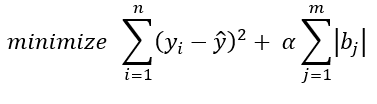

In [32]:
# importamos "lasso (L1) regression" de la misma librería de sklearn
from sklearn.linear_model import Lasso
 
# Ajustamos el algoritmo 
L1_reg = Lasso(alpha = 1)
L1_reg.fit(X_train, y_train)
y_pred_l1 = L1_reg.predict(X_test)

In [33]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(L1_reg.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(L1_reg.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[-0.08422662  0.05332741 -0.          0.         -0.          0.91641177
  0.02752916 -0.58142827  0.27617053 -0.01796679 -0.65064986 -0.78534121]

 Valor de la intersección o coeficiente "b":
43.321297891056446


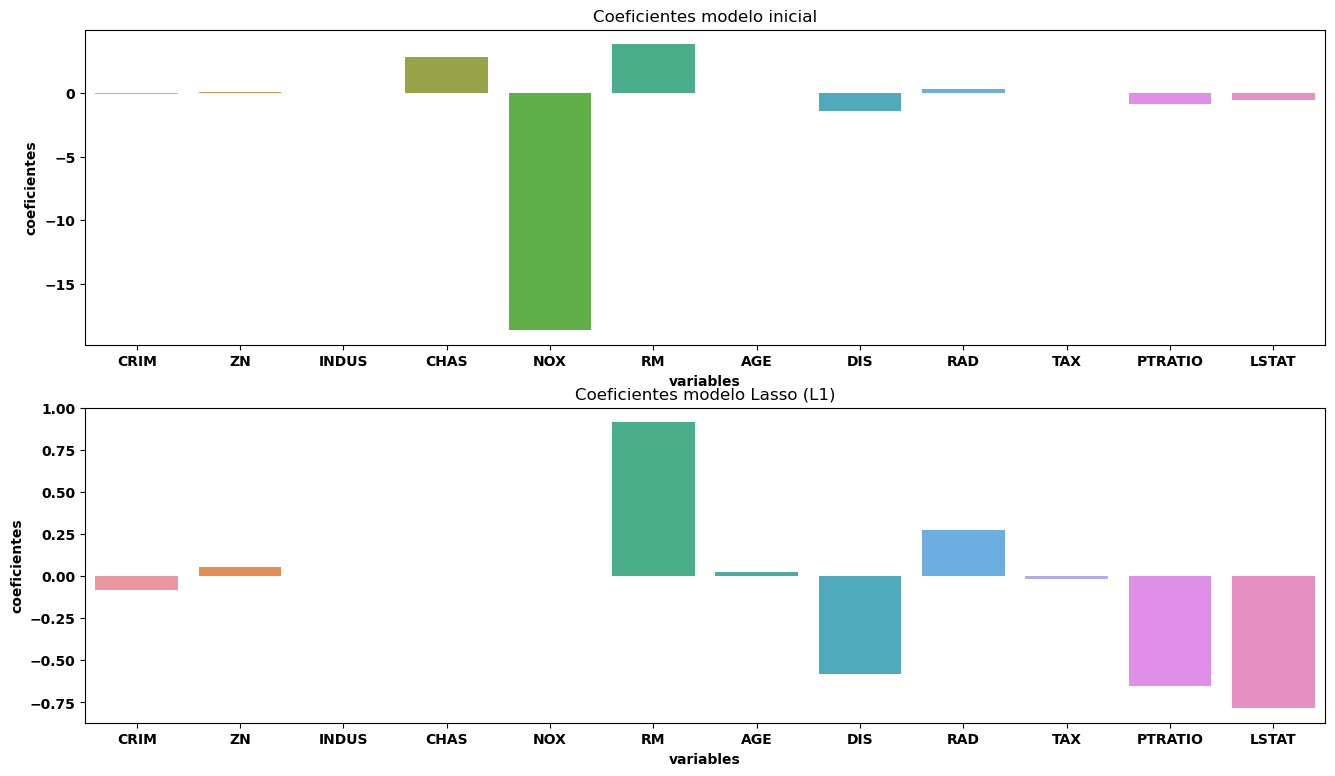

In [34]:
# Visualizamos los coeficientes del modelo
df_coef_l1 = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_coef_l1['coeficientes'] = L1_reg.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef['variables'], y=df_coef['coeficientes'], ax=axes[0], )
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_l1['variables'], y=df_coef_l1['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Lasso (L1)")
plt.show()

In [35]:
df_coef_l1

,variables,coeficientes
0,CRIM,-0.084227
1,ZN,0.053327
2,INDUS,-0.000000
3,CHAS,0.000000
4,NOX,-0.000000
5,RM,0.916412
6,AGE,0.027529
7,DIS,-0.581428
8,RAD,0.276171
9,TAX,-0.017967


Como se puede observar, el modelo *Lasso* ha excluido un par de predictores (al menos 3 variables) respecto al modelo de regresión lineal original.

In [36]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_l1))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_l1)*100)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_l1))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_l1)))
print('R^2 coefficient of determination:', r2_score(y_test, y_pred_l1))

Mean Absolute Error: 3.695606266293276
Mean Absolute Percentage Error: 17.959230482832368
Mean Squared Error: 28.29129002515334
Mean Root Squared Error: 5.318955726940518
R^2 coefficient of determination: 0.6702830977751526


Los resultados del modelo quizá se pueden considerar ligeramente peores que el modelo original, pero seguramente ganamos mucho teniendo un modelo **más simple y más generalizable** que el modelo inicial.  

## Elastic Net


El modelo ***Elastic Net*** consiste en una regularización que combina las penalizaciones de *L1 (Lasso)* y *L2 (Ridge)*.  
El grado de regularización en general se controla por el **hiperparámetro $\alpha$**.  
El grado en que influye cada una de las penalizaciones está controlado por el **hiperparámetro $l1_{ratio}$**.  

Cuando $l1_{ratio}=1$ se aplica el modelo *Lasso* y cuando $l1_{ratio}=0$ se implementa la regularización *Ridge*.  

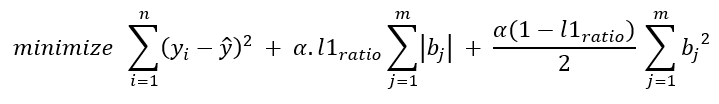

In [37]:
# importamos "Elastic Net regression" de la misma librería de sklearn
from sklearn.linear_model import ElasticNet
 
# Ajustamos el algoritmo indicando unos valoros para los hiperparámetros
Elastic_reg = ElasticNet(alpha=1, l1_ratio=0.8)
Elastic_reg.fit(X_train, y_train)
y_pred_elastic = Elastic_reg.predict(X_test)

In [38]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(Elastic_reg.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(Elastic_reg.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[-0.09333698  0.05535578 -0.00459708  0.         -0.          0.91666112
  0.02662239 -0.63312253  0.29208419 -0.01850576 -0.66287993 -0.78284766]

 Valor de la intersección o coeficiente "b":
43.9007916852823


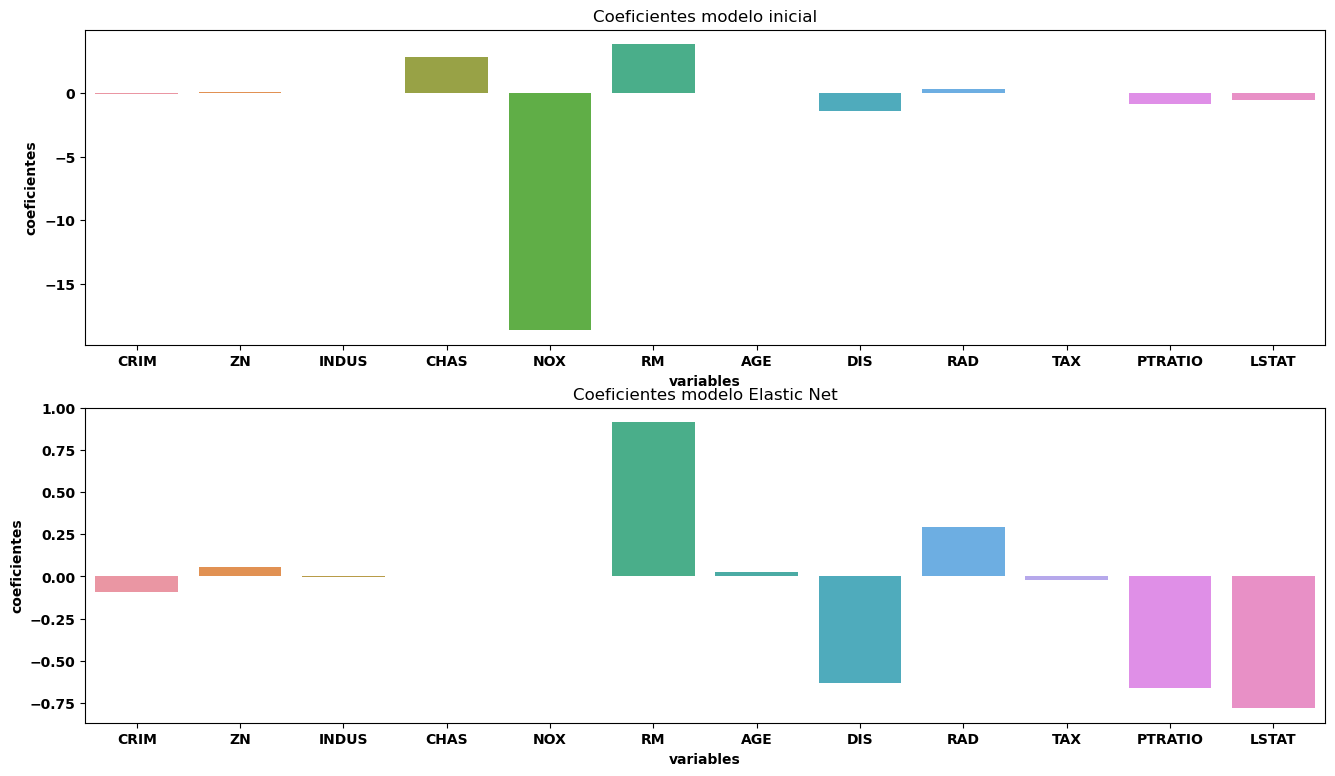

In [39]:
# Visualizamos los coeficientes del modelo
df_coef_elastic = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_coef_elastic['coeficientes'] = Elastic_reg.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef['variables'], y=df_coef['coeficientes'], ax=axes[0], )
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_elastic['variables'], y=df_coef_elastic['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Elastic Net")
plt.show()

In [40]:
df_coef_elastic

,variables,coeficientes
0,CRIM,-0.093337
1,ZN,0.055356
2,INDUS,-0.004597
3,CHAS,0.000000
4,NOX,-0.000000
5,RM,0.916661
6,AGE,0.026622
7,DIS,-0.633123
8,RAD,0.292084
9,TAX,-0.018506


Se aprecia que se han excluido al menos 2 variables respecto al modelo original. Los coeficientes son similares a los coeficientes del modelo *Lasso* posiblemente por su mayor porcentaje de participación en la regularización.

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_elastic))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_elastic)*100)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_elastic))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_elastic)))
print('R^2 coefficient of determination:', r2_score(y_test, y_pred_elastic))

Mean Absolute Error: 3.683205181940034
Mean Absolute Percentage Error: 17.94417281895423
Mean Squared Error: 28.13174670079792
Mean Root Squared Error: 5.303936905808545
R^2 coefficient of determination: 0.6721424732447884


Los resultados de este modelo son muy similares al modelo anterior que se generó aplicando una regularización *Lasso*.

### Elastic Net - Optimización de hiperparámetros 

El mejor modelo en caso de la regularización *Elastic Net* se consigue mediante los **valores óptimos de los hiperparámetros** ($\alpha$ y $l1_{ratio}$).

Estos dos valores como se tratan de los hiperparámetros del modelo, no tienen una estimación previa o un cálculo directo que se pueda aplicar a los datos del modelo. Una forma de obtener los hiperparámetros óptimos consiste en aplicar la técnica de **Cross-Validation (validación cruzada)**.  
En la librería *scikit-learn* podemos usar la función **ElasticNetCV** que nos permite buscar dentro de un rango determinado para encontrar los valores óptimos en base a los errores obtenidos dentro del conjunto de entrenamiento.

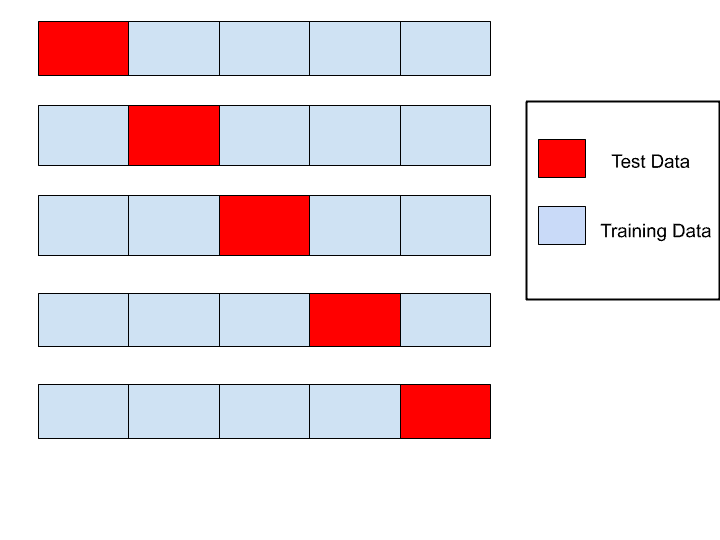

In [42]:
# importamos "ElasticNetCV regression" 
from sklearn.linear_model import ElasticNetCV
 
# Train the model
Elastic_reg_cv = ElasticNetCV(alphas=np.arange(0.6, 5, 0.01),
                              l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                              cv=10,
                              random_state=123)
Elastic_reg_cv.fit(X_train, y_train)
y_pred_elastic_cv = Elastic_reg_cv.predict(X_test)

In [43]:
# Podemos consultar los valores considerados como alpha en la búsqueda
Elastic_reg_cv.alphas_

array([4.99, 4.98, 4.97, 4.96, 4.95, 4.94, 4.93, 4.92, 4.91, 4.9 , 4.89,
       4.88, 4.87, 4.86, 4.85, 4.84, 4.83, 4.82, 4.81, 4.8 , 4.79, 4.78,
       4.77, 4.76, 4.75, 4.74, 4.73, 4.72, 4.71, 4.7 , 4.69, 4.68, 4.67,
       4.66, 4.65, 4.64, 4.63, 4.62, 4.61, 4.6 , 4.59, 4.58, 4.57, 4.56,
       4.55, 4.54, 4.53, 4.52, 4.51, 4.5 , 4.49, 4.48, 4.47, 4.46, 4.45,
       4.44, 4.43, 4.42, 4.41, 4.4 , 4.39, 4.38, 4.37, 4.36, 4.35, 4.34,
       4.33, 4.32, 4.31, 4.3 , 4.29, 4.28, 4.27, 4.26, 4.25, 4.24, 4.23,
       4.22, 4.21, 4.2 , 4.19, 4.18, 4.17, 4.16, 4.15, 4.14, 4.13, 4.12,
       4.11, 4.1 , 4.09, 4.08, 4.07, 4.06, 4.05, 4.04, 4.03, 4.02, 4.01,
       4.  , 3.99, 3.98, 3.97, 3.96, 3.95, 3.94, 3.93, 3.92, 3.91, 3.9 ,
       3.89, 3.88, 3.87, 3.86, 3.85, 3.84, 3.83, 3.82, 3.81, 3.8 , 3.79,
       3.78, 3.77, 3.76, 3.75, 3.74, 3.73, 3.72, 3.71, 3.7 , 3.69, 3.68,
       3.67, 3.66, 3.65, 3.64, 3.63, 3.62, 3.61, 3.6 , 3.59, 3.58, 3.57,
       3.56, 3.55, 3.54, 3.53, 3.52, 3.51, 3.5 , 3.

In [44]:
# Consultamos el valor óptimo seleccionado para "alpha"
Elastic_reg_cv.alpha_

0.6

In [45]:
# Podemos consultar los valores considerados como "l1_ratio"
Elastic_reg_cv.l1_ratio

[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

In [46]:
# Consultamos el valor óptimo seleccionado para "l1_ratio"
Elastic_reg_cv.l1_ratio_

1.0

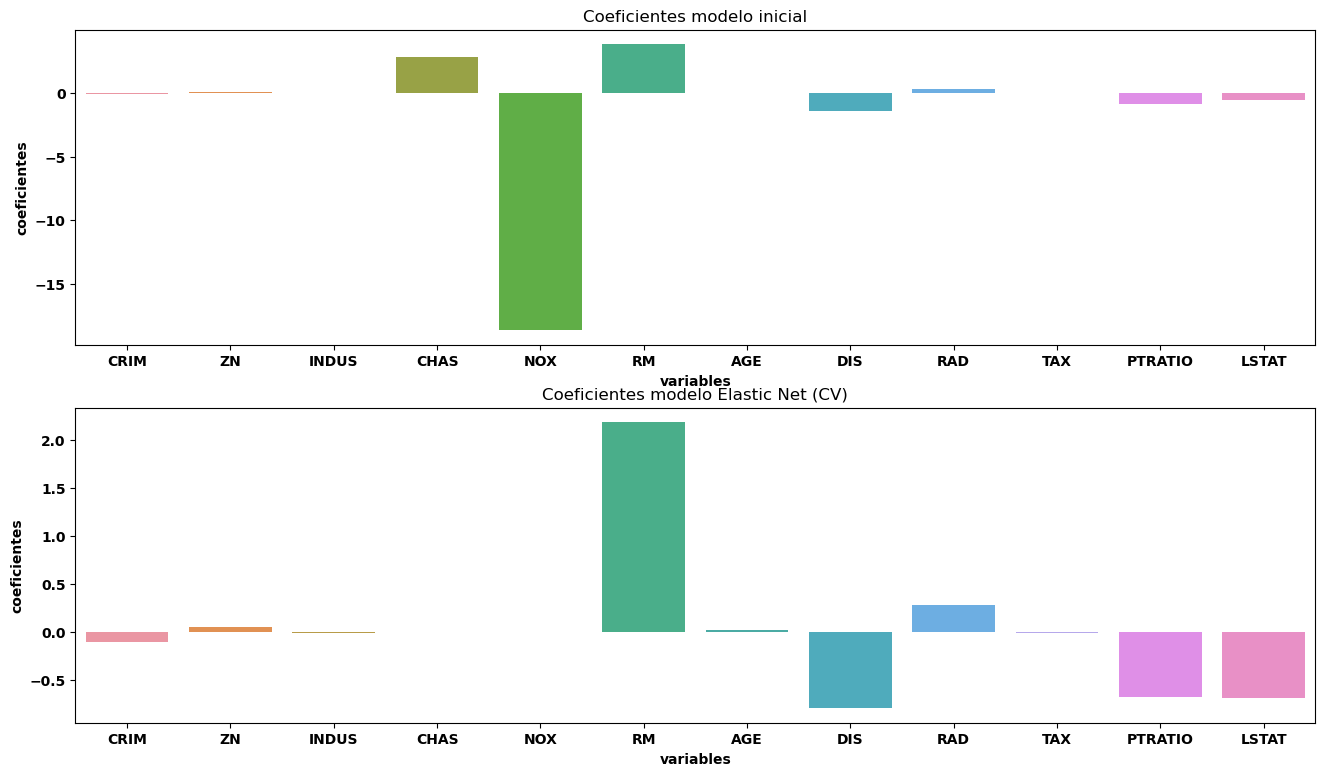

In [47]:
# Visualizamos los coeficientes del modelo
df_coef_elastic_cv = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_coef_elastic_cv['coeficientes'] = Elastic_reg_cv.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef['variables'], y=df_coef['coeficientes'], ax=axes[0], )
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_elastic_cv['variables'], y=df_coef_elastic_cv['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Elastic Net (CV)")
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred_elastic_cv))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test, y_pred_elastic_cv)*100)
print('Mean Squared Error:', mean_squared_error(y_test, y_pred_elastic_cv))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred_elastic_cv)))
print('R^2 coefficient of determination:', r2_score(y_test, y_pred_elastic_cv))

Mean Absolute Error: 3.600337523877384
Mean Absolute Percentage Error: 17.99730220356714
Mean Squared Error: 26.09315491614785
Mean Root Squared Error: 5.10814593724062
R^2 coefficient of determination: 0.6959009574828079


Se ven que los resulados obtenidos con la búsqueda a través de la CV (validación-cruzada) son **ligeramente mejores** que modelo anterior.

---

### **`Ejercicio 7.1`**

Selecciona las 4 variables más importantes según éste último modelo generado con el método `ElasticNetCV` y:  

**`7.1.1`** Construye un modelo tipo regresión lineal múltiple con estos 4 predictores, considerando:  
- `random_state=111`
- `test_size=0.2`  
  
**`7.1.2`** Visualiza los coeficientes del modelo y compáralos con los coeficientes correspondientes al modelo original (primer modelo: _lr_multiple_).  
 
**`7.1.3`** Calcula las siguientes métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores:
- MAE
- MAPE
- MSE
- RMSE
- $R^2$  
  
__Explica__ si este modelo tiene preferencia o no, para ser elegido en práctica como predictor de precio de viviendas comparando con otros modelos.

In [49]:
## Solución
# RM, DIS, PTRATIO, LSTAT
# Ejercicio 7.1.1
'''Construye un modelo tipo regresión lineal múltiple con estos 4 predictores, considerando:  
- `random_state=111`
- `test_size=0.2`'''
variables = df_coef_elastic_cv.sort_values(by=['coeficientes'], ascending=False, key=abs)[:4]['variables'].to_list()
variables_entrada = df_boston[variables]
variable_objetivo = df_boston['target']

In [50]:
#Dividimos, creamos LinearRegression y entrenamos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

entrada_train, entrada_test, objetivo_train, objetivo_test = train_test_split(variables_entrada, variable_objetivo, test_size=0.2, random_state=111)

lr_7_1 = LinearRegression()
lr_7_1.fit(entrada_train,objetivo_train)

LinearRegression()

In [51]:
#lanzamos predicción
pred_7_1 = lr_7_1.predict(entrada_test)

In [52]:
## Solución
# Ejercicio 7.1.2
'''Visualiza los coeficientes del modelo y compáralos con los coeficientes correspondientes al modelo original (primer modelo: _lr_multiple_).'''
df_coef_lr_7_1 = pd.DataFrame(variables_entrada.columns, columns=['variables'])
df_coef_lr_7_1['coeficientes'] = lr_7_1.coef_

df_coef_lr_7_1

,variables,coeficientes
0,RM,4.088983
1,DIS,-0.464202
2,LSTAT,-0.652045
3,PTRATIO,-0.979784


In [53]:
df_lr_multiple_coef = pd.DataFrame(X_multiple.columns, columns=['variables'])
df_lr_multiple_coef['coeficientes'] = lr_multiple.coef_

df_lr_multiple_coef

,variables,coeficientes
0,CRIM,-0.131655
1,ZN,0.048518
2,INDUS,-0.008799
3,CHAS,2.838322
4,NOX,-18.631495
5,RM,3.824786
6,AGE,0.008222
7,DIS,-1.415093
8,RAD,0.278510
9,TAX,-0.012990


Text(0.5, 1.0, 'Coeficientes lr_7_1')

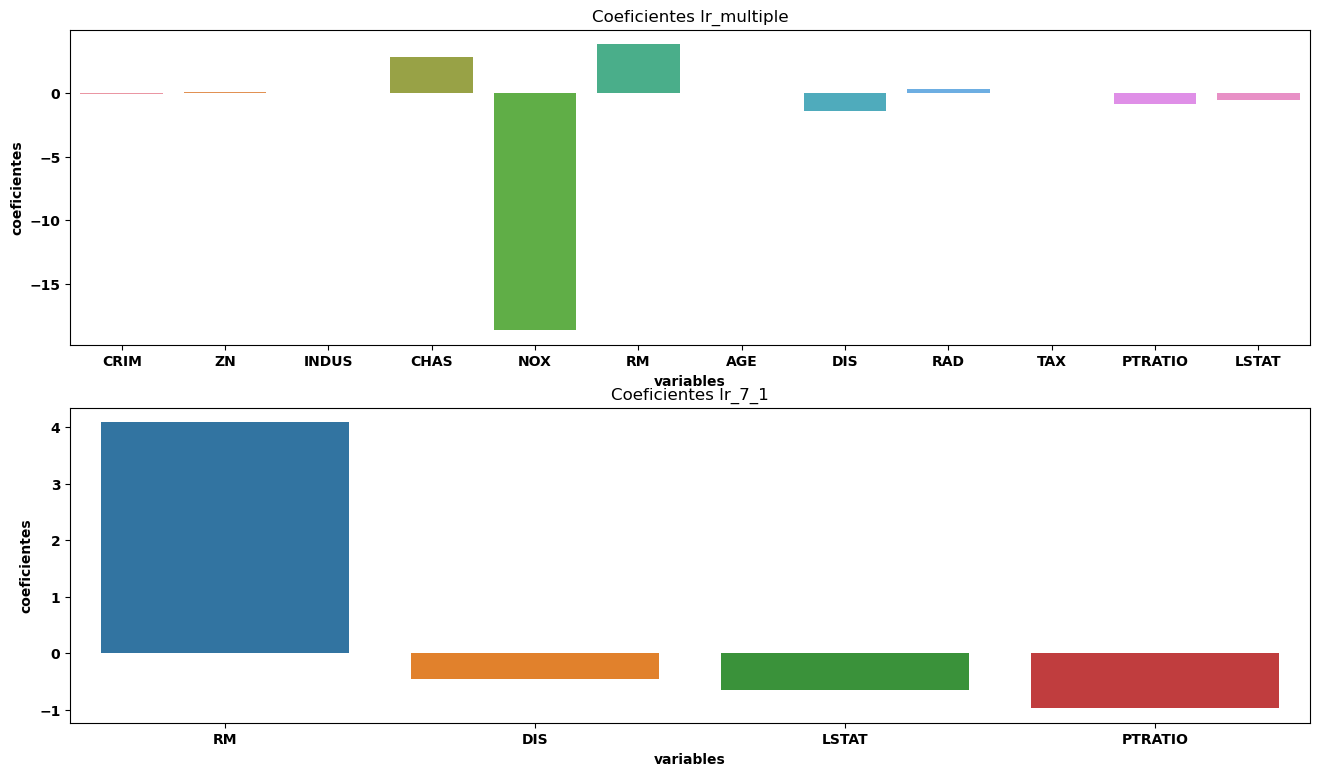

In [54]:
#visualizamos coeficientes
fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x = df_lr_multiple_coef['variables'], y = df_lr_multiple_coef['coeficientes'], ax=axes[0])
axes[0].set_title('Coeficientes lr_multiple')

sns.barplot(x = df_coef_lr_7_1['variables'], y = df_coef_lr_7_1['coeficientes'], ax=axes[1])
axes[1].set_title('Coeficientes lr_7_1')

In [58]:
## Solución
# Ejercicio 7.1.3
'''Calcula las siguientes métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores:
- MAE
- MAPE
- MSE
- RMSE
- $R^2$  
  
__Explica__ si este modelo tiene preferencia o no, para ser elegido en práctica como predictor de precio de viviendas comparando con otros modelos.'''
from networkx import preferential_attachment
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Mean Absolute Error:', mean_absolute_error(objetivo_test, pred_7_1))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(objetivo_test, pred_7_1))
print('Mean Squared Error:', mean_squared_error(objetivo_test, pred_7_1))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(objetivo_test,pred_7_1)))
print('R^2 coefficient of determination:', r2_score(objetivo_test, pred_7_1))



Mean Absolute Error: 3.6999708813598486
Mean Absolute Percentage Error: 0.18919352582013577
Mean Squared Error: 28.012648297933787
Mean Root Squared Error: 5.292697639005443
R^2 coefficient of determination: 0.6911271311883574


#### CONCLUSIÓN
No podríamos indicar aún si el modelo tiene preferencia sobre los demás o no, ya que más o menos los modelos anteriores tienen unas medias absolutas y unos coeficientes de determinacion similares.

---

Ahora intentamos aplicar diferentes métodos de regresión lineal con la regularización de los coeficientes de regresión sobre el [Fisher’s Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)

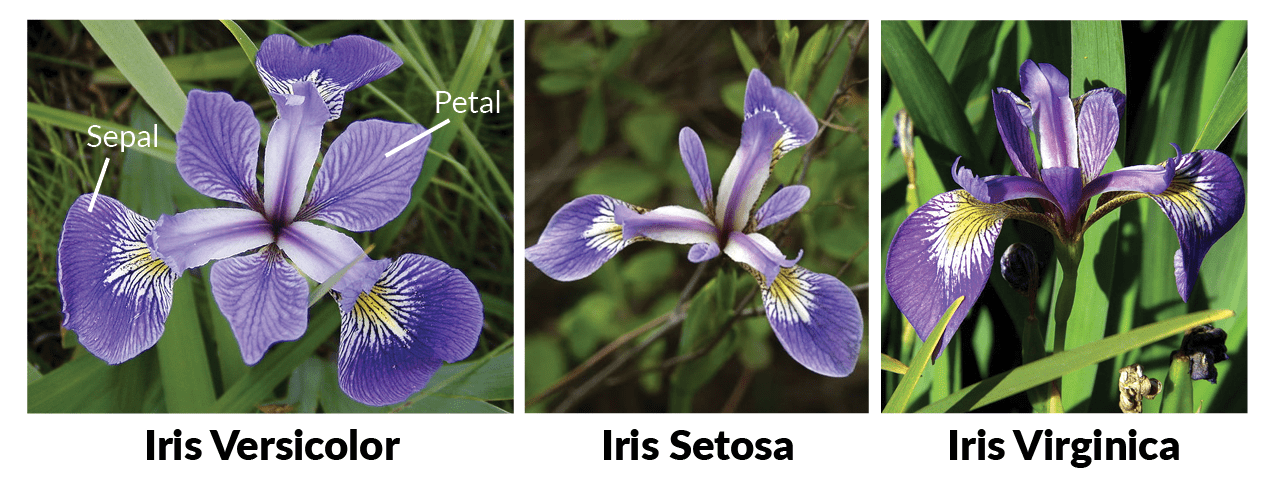

* El conjunto de datos de flores de Iris  es un conjunto de datos multivariante introducido por el estadístico y biólogo británico **Ronald Fisher** 
* El conjunto de datos consta de **50 muestras** de cada una de **las tres especies de Iris**:
    * Iris **setosa**
    * Iris **virginica** 
    * Iris **versicolor**
* Se midieron cuatro características de cada muestra:
    * el **largo** de los **sépalos**, en centímetros.
    * el **ancho** de los **sépalos**, en centímetros. 
    * el **largo** de los **pétalos**, en centímetros.
    * el **ancho** de los **pétalos**, en centímetros.
* Basado en la combinación de estas cuatro características, Fisher desarrolló un modelo discriminante lineal para **distinguir las especies** entre sí.    

In [59]:
from sklearn.datasets import load_iris

# Construimos un dataframe con los datos medidos 
dataset = pd.DataFrame(load_iris()["data"],columns=load_iris()["feature_names"])

# Añadimos la especie como etiqueta
dataset["label"] = load_iris()["target_names"][load_iris()["target"]]

dataset

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [60]:
# Quedarnos solamente con las columnas numéricas
dataset_num = dataset.drop('label', axis=1)
dataset_num

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


### **Planteamiento del problema**: predecir la longitud del sépalo (cm) de las flores iris

Estableceremos las **longitudes de los sépalos** como la variable ***y_iris*** (variable objetivo) y el resto de las variables como predictores del modelo  ***X_iris*** (variables independientes).

In [61]:
X_iris = dataset_num.drop('sepal length (cm)', axis='columns')
y_iris = dataset_num['sepal length (cm)']

print(X_iris)
print(y_iris)

     sepal width (cm)  petal length (cm)  petal width (cm)
0                 3.5                1.4               0.2
1                 3.0                1.4               0.2
2                 3.2                1.3               0.2
3                 3.1                1.5               0.2
4                 3.6                1.4               0.2
..                ...                ...               ...
145               3.0                5.2               2.3
146               2.5                5.0               1.9
147               3.0                5.2               2.0
148               3.4                5.4               2.3
149               3.0                5.1               1.8

[150 rows x 3 columns]
0      5.1
1      4.9
2      4.7
3      4.6
4      5.0
      ... 
145    6.7
146    6.3
147    6.5
148    6.2
149    5.9
Name: sepal length (cm), Length: 150, dtype: float64


In [62]:
# Separar los conjuntos de datos de entrenamiento (Training) y de prueba (Test) para las variables de entrada y salida
from sklearn.model_selection import train_test_split
X_train_ir, X_test_ir, y_train_ir, y_test_ir = train_test_split(X_iris, y_iris, test_size= 0.25, random_state= 123)

In [63]:
# Indicamos el algoritmo de "regresión linel"

from sklearn.linear_model import LinearRegression

lr_iris = LinearRegression()

In [64]:
# Training/Fitting para entrenar el modelo
lr_iris.fit(X_train_ir, y_train_ir)

LinearRegression()

In [65]:
# Conseguir la predicción (para el conjunto de test que son los datos no vistos por el algoritmo en la fase de modelización)
y_pred_ir = lr_iris.predict(X_test_ir)

In [66]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(lr_iris.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(lr_iris.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[ 0.65464427  0.73050862 -0.62879772]

 Valor de la intersección o coeficiente "b":
1.8517174253895075


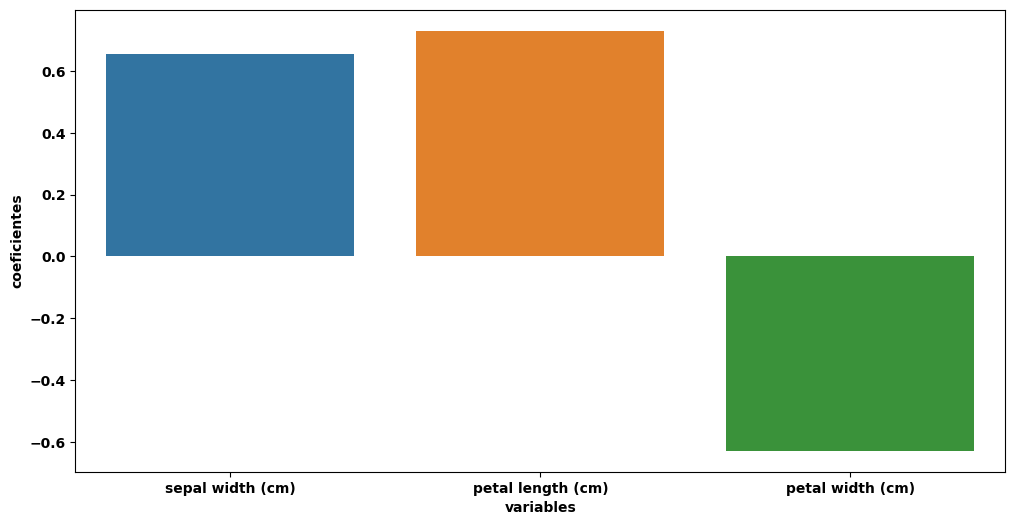

In [67]:
# Creamos una tabla de los parámetros del modelo ajustado y los visualizamos
df_coef_ir = pd.DataFrame(X_iris.columns, columns=['variables'])
df_coef_ir['coeficientes'] = lr_iris.coef_

sns.barplot(x=df_coef_ir['variables'], y=df_coef_ir['coeficientes'])
plt.show()

In [68]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test_ir, y_pred_ir))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_ir, y_pred_ir)*100)
print('Mean Squared Error:', mean_squared_error(y_test_ir, y_pred_ir))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test_ir, y_pred_ir)))
print('R^2 coefficient of determination:', r2_score(y_test_ir, y_pred_ir))

Mean Absolute Error: 0.2828541957182807
Mean Absolute Percentage Error: 4.941203228291833
Mean Squared Error: 0.11930339817249092
Mean Root Squared Error: 0.3454032399565628
R^2 coefficient of determination: 0.8616861039388237


Como primera regularización aplicamos el modelo **Lasso (L1)**

In [69]:
# importamos "lasso (L1) regression" de la misma librería de sklearn
from sklearn.linear_model import Lasso
 
# Ajustamos el modelo 
L1_reg_ir = Lasso(alpha = 1)
L1_reg_ir.fit(X_train_ir, y_train_ir)
y_pred_l1_ir = L1_reg_ir.predict(X_test_ir)

In [70]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(L1_reg_ir.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(L1_reg_ir.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[-0.          0.05709709  0.        ]

 Valor de la intersección o coeficiente "b":
5.645583477117784


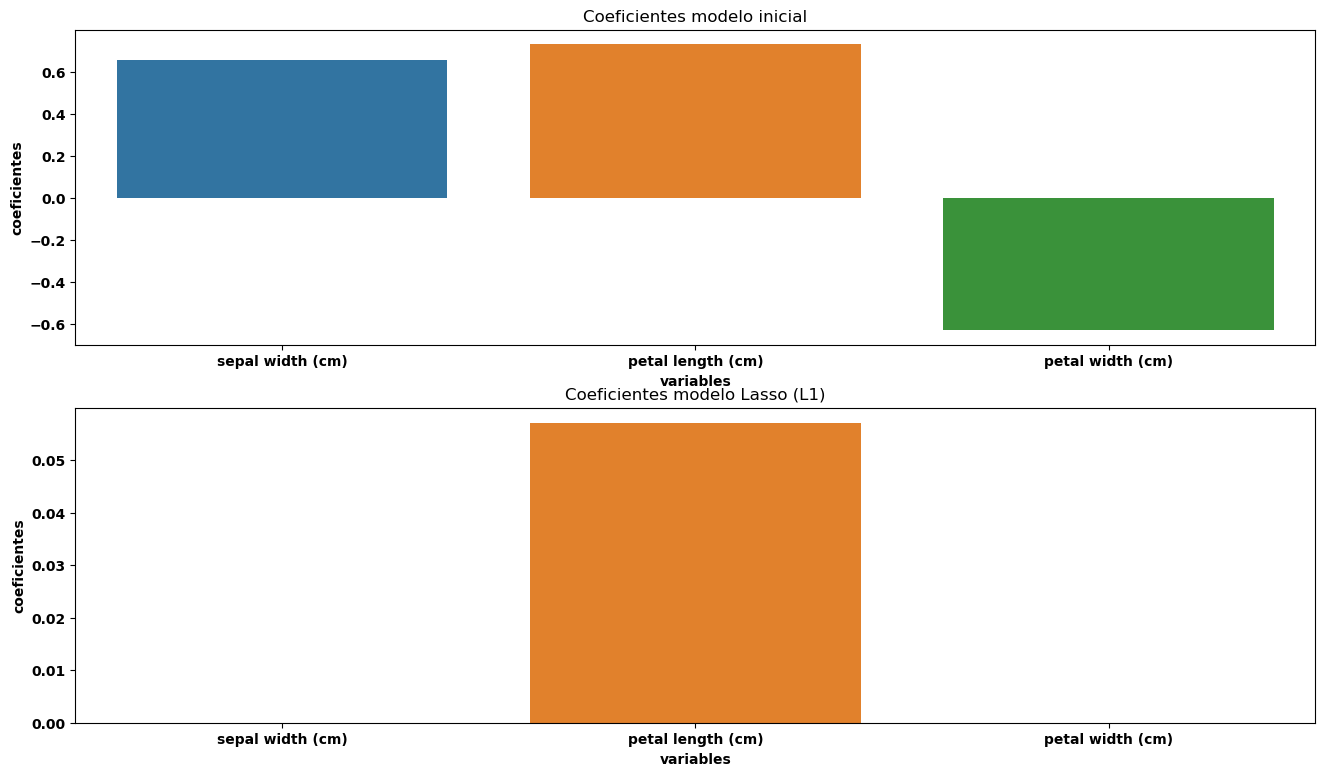

In [71]:
# Visualizamos los coeficientes del modelo
df_coef_l1_ir = pd.DataFrame(X_iris.columns, columns=['variables'])
df_coef_l1_ir['coeficientes'] = L1_reg_ir.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef_ir['variables'], y=df_coef_ir['coeficientes'], ax=axes[0])
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_l1_ir['variables'], y=df_coef_l1_ir['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Lasso (L1)")
plt.show()

Como se puede observar, el modelo *Lasso* ha dejado solamente una variable como predictor.

In [72]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test_ir, y_pred_l1_ir))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_ir, y_pred_l1_ir)*100)
print('Mean Squared Error:', mean_squared_error(y_test_ir, y_pred_l1_ir))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test_ir, y_pred_l1_ir)))
print('R^2 coefficient of determination:', r2_score(y_test_ir, y_pred_l1_ir))

Mean Absolute Error: 0.6849294562362616
Mean Absolute Percentage Error: 12.09618277305041
Mean Squared Error: 0.7026378774991608
Mean Root Squared Error: 0.8382349774968597
R^2 coefficient of determination: 0.18539971328768612


El rendimiento de este modelo claramente es inferior y no tiene mucha capacidad predictiva por los resultados obtenidos.

Ahora aplicamos el método de ***Ridge Regression*** sobre el mismo planteamiento del dataset de Iris: 

In [73]:
# importamos el "ridge regression"
from sklearn.linear_model import Ridge
 
# Entrenamos el modelo L2
L2_reg_ir = Ridge(alpha = 1)
L2_reg_ir.fit(X_train_ir, y_train_ir)
y_pred_l2_ir = L2_reg_ir.predict(X_test_ir)

In [74]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(L2_reg_ir.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(L2_reg_ir.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[ 0.58942098  0.64936485 -0.45491125]

 Valor de la intersección o coeficiente "b":
2.1457688792934237


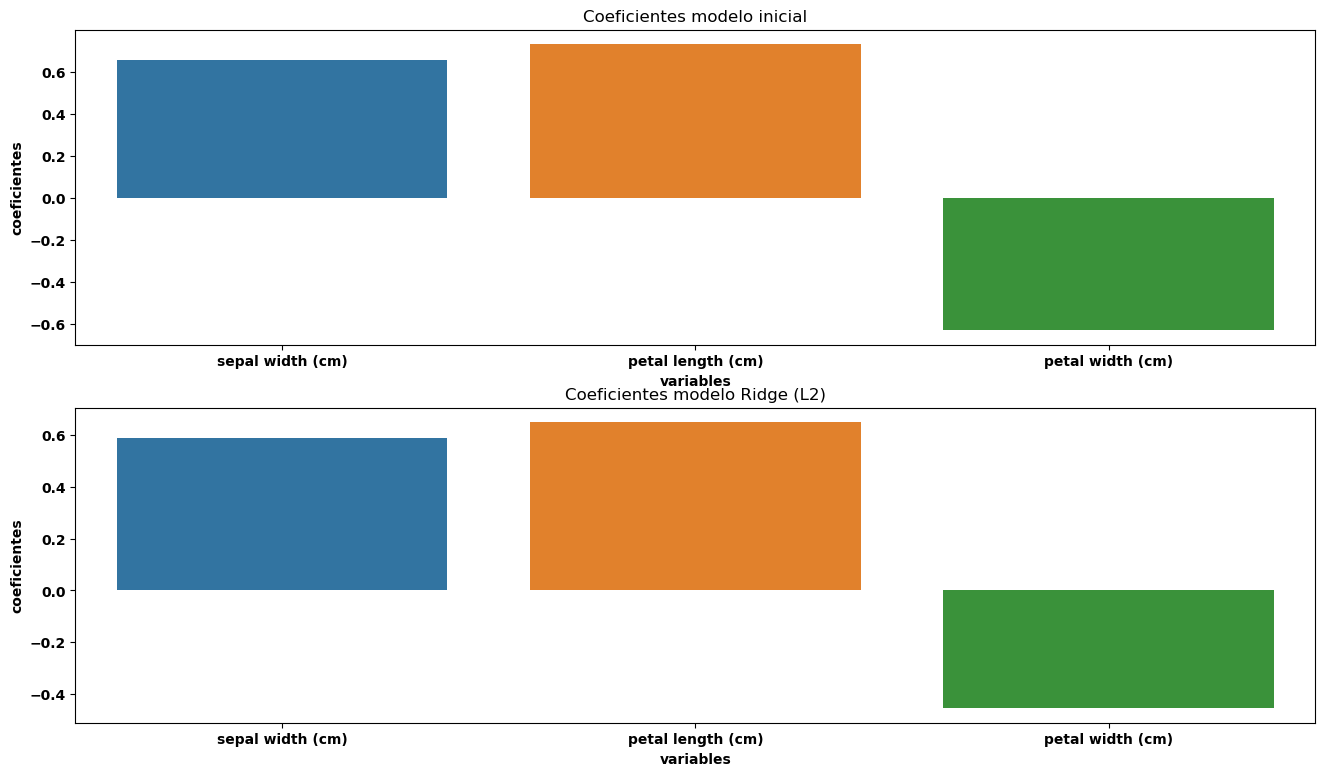

In [75]:
# Visualizamos los coeficientes del modelo
df_coef_l2_ir = pd.DataFrame(X_iris.columns, columns=['variables'])
df_coef_l2_ir['coeficientes'] = L2_reg_ir.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef_ir['variables'], y=df_coef_ir['coeficientes'], ax=axes[0])
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_l2_ir['variables'], y=df_coef_l2_ir['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Ridge (L2)")
plt.show()

El modelo de L2 incluye las 3 variables independientes como el modelo original, con los coeficientes similares y ligeramente más pequeños.

In [76]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test_ir, y_pred_l2_ir))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_ir, y_pred_l2_ir)*100)
print('Mean Squared Error:', mean_squared_error(y_test_ir, y_pred_l2_ir))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test_ir, y_pred_l2_ir)))
print('R^2 coefficient of determination:', r2_score(y_test_ir, y_pred_l2_ir))

Mean Absolute Error: 0.28388765658567466
Mean Absolute Percentage Error: 4.96454435733666
Mean Squared Error: 0.11771093991550009
Mean Root Squared Error: 0.34309027954096877
R^2 coefficient of determination: 0.863532313763633


Las métricas del modelo indican que los resultados **prácticamente son iguales** que el modelo original sin regularización.

Ahora aplicamos el modelo **Elastic Net** que pretende combinar las dos penalizaciones anteriores:

In [77]:
# importamos "Elastic Net regression"
from sklearn.linear_model import ElasticNet
 
# Ajustamos el algoritmo indicando unos valoros para los hiperparámetros
Elastic_reg_ir = ElasticNet(alpha=0.1,l1_ratio=0.5)
Elastic_reg_ir.fit(X_train_ir, y_train_ir)
y_pred_elastic_ir = Elastic_reg_ir.predict(X_test_ir)

In [78]:
print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(Elastic_reg_ir.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(Elastic_reg_ir.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[0.12055477 0.38878762 0.        ]

 Valor de la intersección o coeficiente "b":
4.0080440837722815


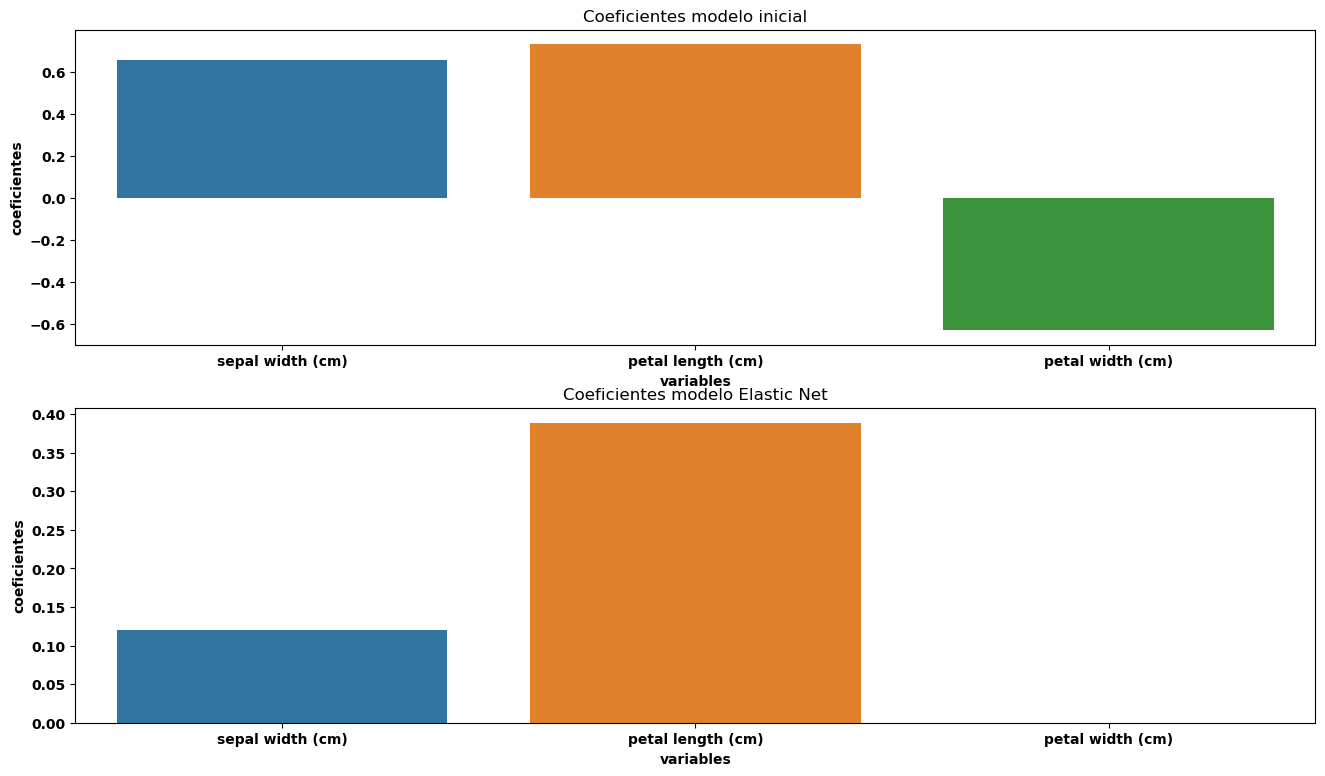

In [79]:
# Visualizamos los coeficientes del modelo
df_coef_elastic_ir = pd.DataFrame(X_iris.columns, columns=['variables'])
df_coef_elastic_ir['coeficientes'] = Elastic_reg_ir.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef_ir['variables'], y=df_coef_ir['coeficientes'], ax=axes[0])
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_elastic_ir['variables'], y=df_coef_elastic_ir['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Elastic Net")
plt.show()

Se puede apreciar que este nuevo modelo tiene un predictor menos que el modelo original, y el resto de los coeficientes más pequeños. 

In [80]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Métricas para evaluar la calidad del modelo
print('Mean Absolute Error:', mean_absolute_error(y_test_ir, y_pred_elastic_ir))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_ir, y_pred_elastic_ir)*100)
print('Mean Squared Error:', mean_squared_error(y_test_ir, y_pred_elastic_ir))
print('Mean Root Squared Error:', np.sqrt(mean_squared_error(y_test_ir, y_pred_elastic_ir)))
print('R^2 coefficient of determination:', r2_score(y_test_ir, y_pred_elastic_ir))

Mean Absolute Error: 0.3450822817104095
Mean Absolute Percentage Error: 5.9839353016359125
Mean Squared Error: 0.18012646823823664
Mean Root Squared Error: 0.424413086789553
R^2 coefficient of determination: 0.7911711318587158


Los resultados de este modelo parecen relativamente aceptables. En un principio son bastante mejores que el modelo L1 y por otra parte ligeramente inferiores respecto al modelo L2.

---

### **`Ejercicio 7.2`**

Realiza una busqueda en estos rangos indicados con el método `ElasticNetCV` y sigue los siguientes puntos:

- $\alpha$:  valores entre `0.02` y `0.5` con pasos de una centésima.
- $l1_{ratio}$:  valores iguales a `0.9`, `0.95`, `0.99` y `1`
- `cv=10`
- `random_state=123` 

**`7.2.1`** Construye un modelo tipo regresión lineal múltiple con los hiperparámetros resultantes.  
  
**`7.2.2`** Visualiza los coeficientes del modelo y compáralos con los coeficientes correspondientes al modelo original (primer modelo sin regularización: _lr_iris_).  sin .predict

**`7.2.3`** Calcula estas métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores.
- MAE
- MAPE
- MSE
- RMSE
- $R^2$  
  
__Explica__ si este modelo tiene preferencia o no, para ser elegido en práctica como predictor de largos de sépalos en (cm) comparando con otros modelos.

In [82]:
## Solución
# Ejercicio 7.2.1
from sklearn.linear_model import ElasticNetCV

#Train model
elastic_net_cv = ElasticNetCV(alphas=np.arange(0.02, 0.5, 0.01),
                              l1_ratio=[0.9,0.95,0.99,1],
                              cv=10,
                              random_state=123)
elastic_net_cv.fit(X_train_ir, y_train_ir)
y_pred_elastic_cv = elastic_net_cv.predict(X_test_ir)

In [83]:

print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('\n', 'Valor de las pendientes o coeficientes "a":')
print(elastic_net_cv.coef_)
print('\n', 'Valor de la intersección o coeficiente "b":')
print(elastic_net_cv.intercept_)

DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE

 Valor de las pendientes o coeficientes "a":
[ 0.4216792   0.43810475 -0.        ]

 Valor de la intersección o coeficiente "b":
2.90232550808614


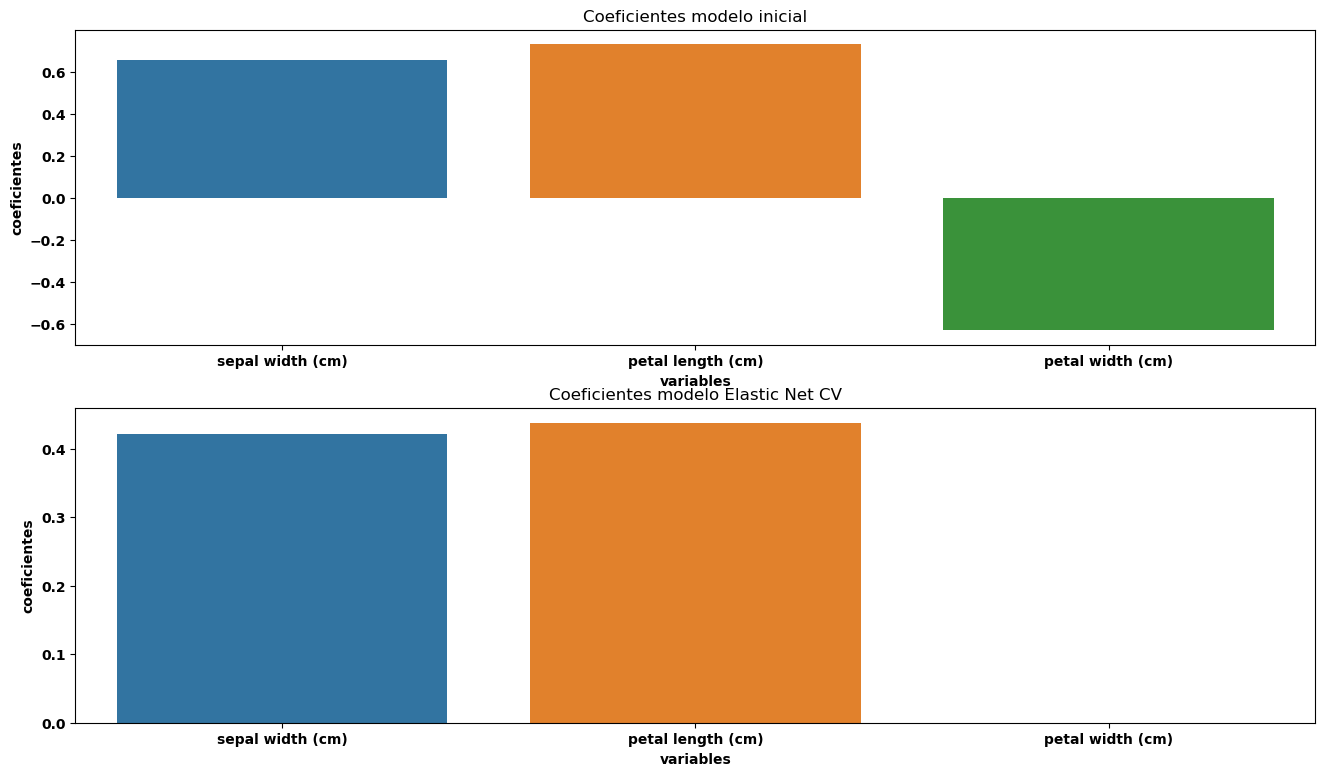

In [87]:
## Solución
# Ejercicio 7.2.2
'''Visualiza los coeficientes del modelo y compáralos con los coeficientes correspondientes al modelo original (primer modelo sin regularización: _lr_iris_).  sin .predict'''

from matplotlib.pyplot import fignum_exists


df_coef_netcv = pd.DataFrame(X_iris.columns, columns=['variables'])
df_coef_netcv['coeficientes'] = elastic_net_cv.coef_

fig, axes = plt.subplots(2, 1, figsize=(16,9))
sns.barplot(x=df_coef_ir['variables'], y=df_coef_ir['coeficientes'], ax=axes[0])
axes[0].set_title("Coeficientes modelo inicial")

sns.barplot(x=df_coef_netcv['variables'], y=df_coef_netcv['coeficientes'], ax=axes[1])
axes[1].set_title("Coeficientes modelo Elastic Net CV")
plt.show()

In [88]:
## Solución
# Ejercicio 7.2.3
'''Calcula estas métricas para evaluar tu modelo y analiza su rendimiendo en comparación con modelos anteriores.
- MAE
- MAPE
- MSE
- RMSE
- $R^2$  
  
__Explica__ si este modelo tiene preferencia o no, para ser elegido en práctica como predictor de largos de sépalos en (cm) comparando con otros modelos.'''
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Mean Absolute Error:', mean_absolute_error(y_test_ir, y_pred_elastic_cv))
print('Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_test_ir, y_pred_elastic_cv)*100)
print('Mean Squared Error:', mean_squared_error(y_test_ir, y_pred_elastic_cv))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test_ir, y_pred_elastic_cv)))
print('R^2 coefficient of determination:', r2_score(y_test_ir, y_pred_elastic_cv))

Mean Absolute Error: 0.3012280502595851
Mean Absolute Percentage Error: 5.2168766230008865
Mean Squared Error: 0.13027160027434567
Root Mean Squared Error: 0.36093157284220184
R^2 coefficient of determination: 0.8489701646719428


#### CONCLUSIÓN
No creo que podamos indicar si este modelo podría tener la preferencia o no ya que su coeficiente de determinacion y demás medias son bastante similares a la de los modelos anteriores.